# **Explore Data Sets**

**Goal**: To explore the dataset by looking at images of crops, some with healthy and some with different diseases.

**Objectives**

- Check properties of the image data.
- Normalize the dataset.
- Check the number of data points in each class.
- Balance the classes, so each ha the same number of observations.

In [101]:
import os
import random
from shutil import copy2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [102]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.5.1+cpu
torchvision version :  0.20.1+cpu
numpy version :  1.26.3
matplotlib version :  3.8.3
Python 3.12.1


**1. Exploring Data**

In [103]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

print("Data directory:", train_dir)

Data directory: data_p2\train


In [104]:
classes = os.listdir(train_dir)
classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

Open an image with PIL

In [105]:
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

Looking at some healthy plants:

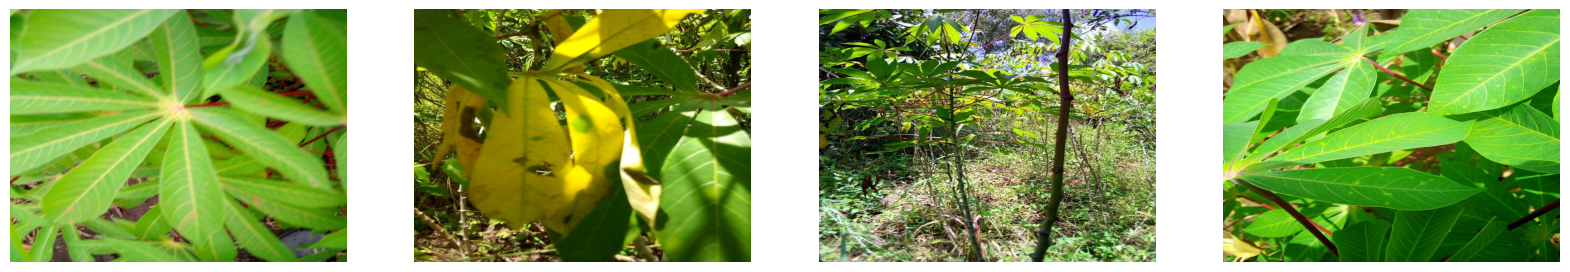

In [106]:
sample_images(train_dir, "cassava-healthy")

Green Motle

cassava-healthy


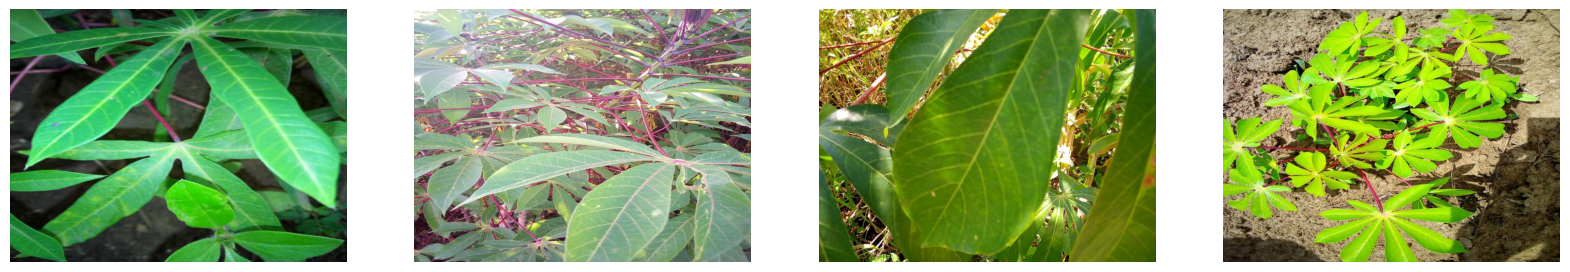

In [107]:
class_name = classes[3]
print(class_name)

sample_images(train_dir, class_name)

bacterial blight:

cassava-bacterial-blight-cbb


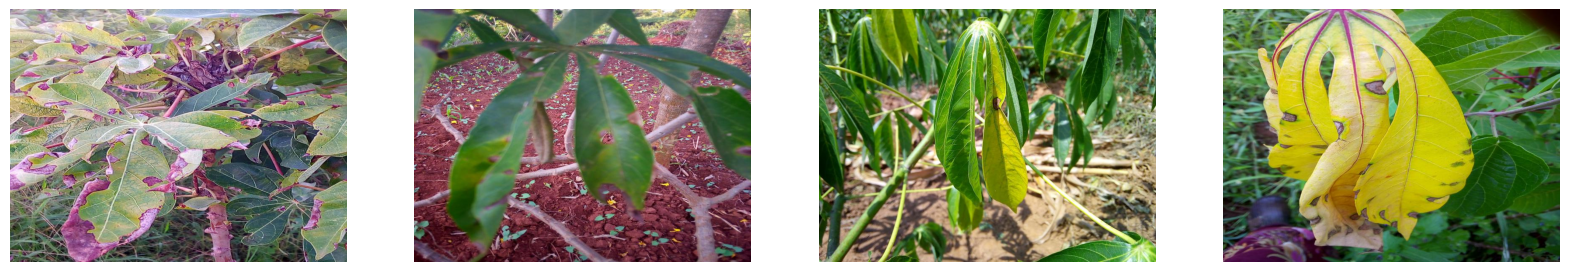

In [108]:
class_name = classes[0]
print(class_name)

sample_images(train_dir, class_name)

Mosaic:

cassava-mosaic-disease-cmd


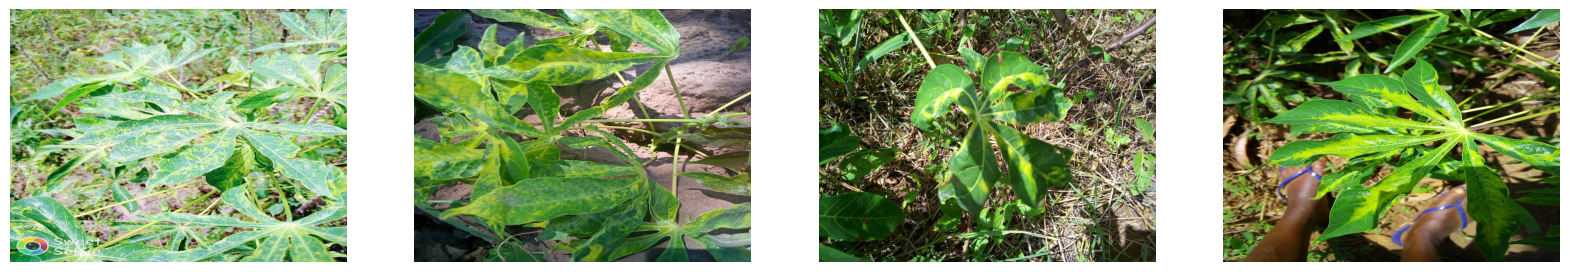

In [109]:
class_name = classes[4]
print(class_name)

sample_images(train_dir, class_name)

**1. Preparing Data**

We create a transformation that:
- Convert any grayscale images to RGB format with a custom class.
- Resize the image, so that they're all the same size (we chose 224 x 224, but other sizes would work as well).
- Convert the image to a Tensor of pixel values.

In [110]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [111]:
transform_basic = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [112]:
batch_size = 32
dataset = datasets.ImageFolder(root=train_dir, transform=transform_basic)
dataset_loader = DataLoader(dataset, batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


**2. Normalize Data**

In [113]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [114]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/669 [00:00<?, ?it/s]

Mean: tensor([0.4303, 0.4967, 0.3134])
Standard deviation: tensor([0.2206, 0.2236, 0.2117])


Transform norm - normalize dataset_loader:

In [115]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [116]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size)

batch_shape = next(iter(norm_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


Verify normalization:

In [117]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/669 [00:00<?, ?it/s]

Mean: tensor([-6.6027e-07, -1.0346e-06, -2.7157e-07])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


**3. Train-Validation Split**

In [118]:
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [119]:
from training import class_counts

Proportion of classes:

In [120]:
train_counts = class_counts(train_dataset)
train_counts

  0%|          | 0/17118 [00:00<?, ?it/s]

cassava-bacterial-blight-cbb           880
cassava-brown-streak-disease-cbsd     1777
cassava-green-mottle-cgm              1883
cassava-healthy                       2102
cassava-mosaic-disease-cmd           10476
dtype: int64

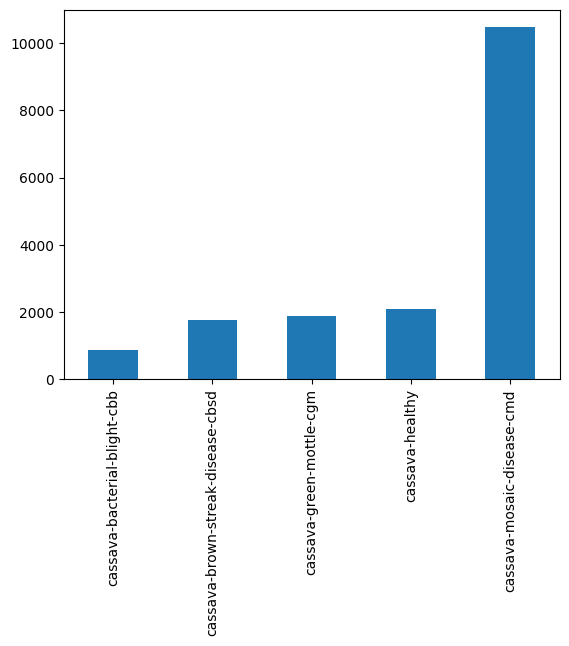

In [121]:
train_counts.plot(kind="bar");

**4. Unbalanced Classes**

- Undersampling - Since we can't get more images, we'll remove some from the larger classes.

In [122]:
def undersample_dataset(dataset_dir, output_dir, target_count=None):
    """
    Undersample the dataset to have a uniform distribution across classes.

    Parameters:
    - dataset_dir: Path to the directory containing the class folders.
    - output_dir: Path to the directory where the undersampled dataset will be stored.
    - target_count: Number of instances to keep in each class. If None, the class with the least instances will set the target.
    """
    # Mapping each class to its files
    classes_files = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            files = os.listdir(class_dir)
            classes_files[class_name] = files

    # Determine the minimum class size if target_count is not set
    if target_count is None:
        target_count = min(len(files) for files in classes_files.values())

    # Creating the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Perform undersampling
    for class_name, files in classes_files.items():
        print("Copying images for class", class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Randomly select target_count images
        selected_files = random.sample(files, min(len(files), target_count))

        # Copy selected files to the output directory
        for file_name in tqdm(selected_files):
            src_path = os.path.join(dataset_dir, class_name, file_name)
            dst_path = os.path.join(class_output_dir, file_name)
            copy2(src_path, dst_path)

    print(f"Undersampling completed. Each class has up to {target_count} instances.")

Create a variable output_dir for the new directory data_p2/data_undersampled/train:

In [123]:
output_dir = os.path.join("data_p2", "data_undersampled", "train")
print("Output directory:", output_dir)

Output directory: data_p2\data_undersampled\train


Erase the directory if it already exists:

In [124]:
! rm -rf {output_dir}

'rm' is not recognized as an internal or external command,
operable program or batch file.


Copy files:

In [125]:
undersample_dataset(train_dir, output_dir)

Copying images for class cassava-bacterial-blight-cbb


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class cassava-brown-streak-disease-cbsd


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class cassava-green-mottle-cgm


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class cassava-healthy


  0%|          | 0/1087 [00:00<?, ?it/s]

Copying images for class cassava-mosaic-disease-cmd


  0%|          | 0/1087 [00:00<?, ?it/s]

Undersampling completed. Each class has up to 1087 instances.


 Create a dataset with ImageFolder using the data in the output_dir. Transform the data with the transform_norm:

In [126]:
undersampled_dataset = datasets.ImageFolder(output_dir, transform_norm)

In [127]:
undersampled_dataset.classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

In [128]:
# data_dir = output_dir 
# class_folders = os.listdir(data_dir)
# class_counts_dict = {}
# for class_folder in class_folders:
#     folder_path = os.path.join(data_dir, class_folder)
#     if os.path.isdir(folder_path):
#         num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
#         class_counts_dict[class_folder] = num_files
# under_counts= pd.Series(class_counts_dict)

In [129]:
under_counts

cassava-bacterial-blight-cbb         1087
cassava-brown-streak-disease-cbsd    1087
cassava-green-mottle-cgm             1087
cassava-healthy                      1087
cassava-mosaic-disease-cmd           1087
dtype: int64

  0%|          | 0/8180 [00:00<?, ?it/s]

<Axes: >

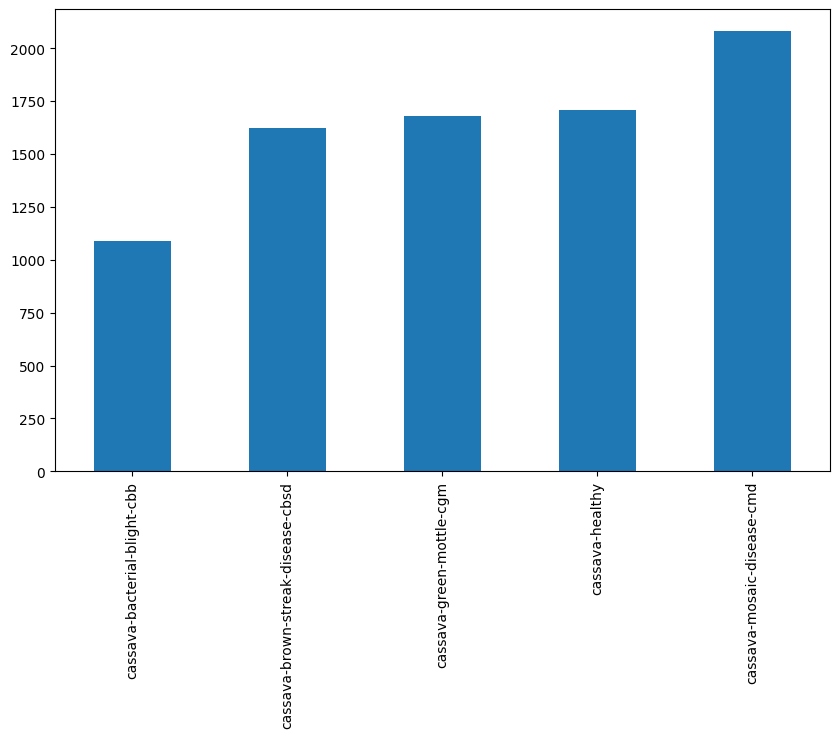

In [130]:
# Important, don't change this
fig, ax = plt.subplots(figsize=(10, 6))

under_counts = class_counts(undersampled_dataset)

# Create a bar chart from under_counts
under_counts.plot(kind="bar", ax=ax)
